In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Helper Functions

Defining function to remove outliers. I am going to remove outliers using z-score method

Parameters:
* df = the data frame
* sigma = the value of sigma, I will assign sigma to have a value of 3
* unique = number of unique rows in each columns. The rows need to have enough variance for it to have outliers. I will assign value of 10 to unique variable

In [5]:
def RemoveOutliers(df, unique, sigma=3):
    for col in df.columns:
      if df[col].nunique() > unique:
        df = df[(df[col] > (df[col].mean() - df[col].std()*sigma )) & (df[col] < (df[col].mean() + df[col].std()*sigma ))]
    return df

# Function for preprocessing the data
def preprocessing_data(df):
    df["DestType"] = [x[0] for x in df['nameDest']] # seperates C and M in each value in nameDest column and stores it in a new column DestType
    df['nameDest'] = np.array([x[1:] for x in df['nameDest']]).astype(np.int64) # removes C and M in each value in nameDest column and saves it as integers
    df['nameOrig'] = np.array([x[1:] for x in df['nameOrig']]).astype(np.int64) # removes C and M in each value in nameOrig column and saves it as integers
    return df

### Data Exploration

In [6]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv') # read the data from the CSV file

In [7]:
df.head() # displays rows from the top of the dataframe (default is 5 rows)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
df.isnull().sum() # mark null values as True and returns sum of number of True values in each column

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
df.duplicated().sum() # shows number of duplicated entries in the dataframe

0

In [10]:
df.describe().round(2) # calculates statistical values and rounds them to 2 decimal places

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6.362620e+06,6.362620e+06,6362620.00,6362620.0
mean,243.40,179861.90,833883.10,855113.67,1.100702e+06,1.224996e+06,0.00,0.0
std,142.33,603858.23,2888242.67,2924048.50,3.399180e+06,3.674129e+06,0.04,0.0
min,1.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
25%,156.00,13389.57,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
50%,239.00,74871.94,14208.00,0.00,1.327057e+05,2.146614e+05,0.00,0.0
75%,335.00,208721.48,107315.18,144258.41,9.430367e+05,1.111909e+06,0.00,0.0
max,743.00,92445516.64,59585040.37,49585040.37,3.560159e+08,3.561793e+08,1.00,1.0


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [11]:
df.sample(8) # randomly selects rows of data (in this case 8) and displays them

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6039467,482,TRANSFER,1451083.08,C1888769481,1451083.08,0.00,C1653981424,0.00,0.00,1,0
857018,41,PAYMENT,10644.46,C1900948058,3035.00,0.00,M2136316745,0.00,0.00,0,0
159114,12,CASH_IN,167446.32,C1701371393,26135.00,193581.32,C1296097250,0.00,10488.08,0,0
2551827,206,PAYMENT,16154.51,C1987003973,0.00,0.00,M650315000,0.00,0.00,0,0
3467910,258,PAYMENT,10605.42,C620211541,38138.94,27533.52,M2025144233,0.00,0.00,0,0
1986527,179,CASH_OUT,78340.95,C1209531795,20084.00,0.00,C1911159398,0.00,78340.95,0,0
2381970,194,CASH_OUT,45514.78,C665784488,9242.00,0.00,C1161377462,1295496.02,1341010.80,0,0
6093423,522,PAYMENT,1410.58,C398506335,194.00,0.00,M1446575879,0.00,0.00,0,0


In [12]:
# Some Irregularities in the Data:
# 1. In case of cash transferred from origin to destination, newbalanceDest sometimes doesn't reflect that change (possible fraud).
# 2. In case of cash transferred from origin to destination, the required amount is not in oldbalanceOrg (possible fraud).
# 3. Values in nameOrig sometimes have 9 digits instead of 10.
# 4. Single transactions of 200000 and above should be marked as 1 in isFlaggedFraud column yet a lot of times they are not.

### Data Preprocessing

In [75]:
df_cp = df.copy() # made a copy of the dataframe

df_cp = preprocessing_data(df_cp) # preprocessed the dataframe

In [76]:
df_cp.sample(6)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,DestType
4504860,325,TRANSFER,1417967.72,865920350,78072.00,0.00,1715747042,0.00,1417967.72,0,0,C
3876994,283,CASH_OUT,16877.75,464254824,12958.00,0.00,73034582,4516.87,21394.61,0,0,C
4494036,325,CASH_IN,27651.62,419674876,5253392.38,5281043.99,907298691,683147.27,655495.65,0,0,C
32881,8,PAYMENT,11979.17,392830714,178160.27,166181.10,2138528304,0.00,0.00,0,0,M
149871,12,TRANSFER,1119025.66,694751432,24480.00,0.00,1230583314,151322.77,1443181.85,0,0,C
1631447,157,CASH_OUT,17539.14,159833769,0.00,0.00,1754164558,4004315.75,4021854.89,0,0,C


### Data Visualization

#### Pie Plot

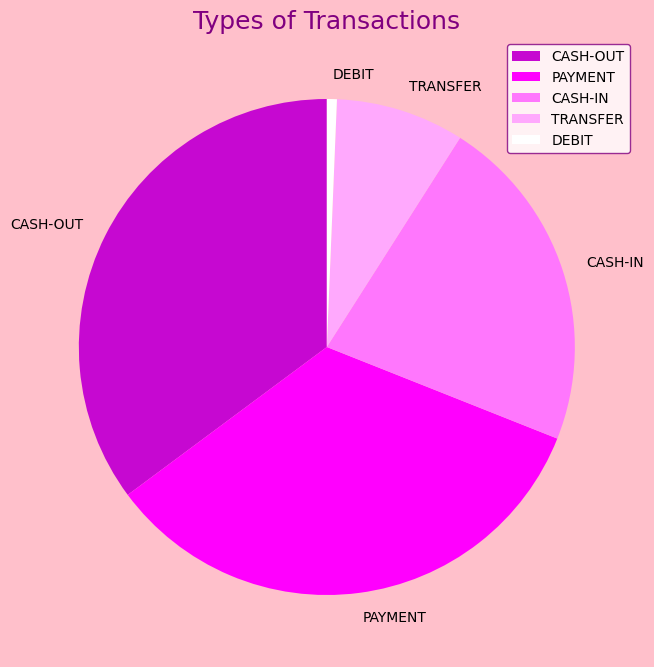

In [15]:
fig = plt.figure() # making object of figure class
color = ['#c608d1', '#ff00fe', '#ff77fd', '#ffA9fd', 'white'] # color for the pie chart
label = ['CASH-OUT', 'PAYMENT', 'CASH-IN', 'TRANSFER', 'DEBIT'] # label for each divisions of the pie chart
plt.pie(df_cp['type'].value_counts(), colors=color, labels=label, startangle=90) # making the chart with start angle for plotting
# set to 90 degrees
fig.patch.set_facecolor('pink') # background color set to pink
fig.set_size_inches(8, 9) # total size of the chart 8 x 9 inches
plt.legend(edgecolor='purple') # legend shown with purple edges instead of the default color white
plt.title('Types of Transactions', fontsize=18, color='purple') # title set with fontsize of 18 and purple color
plt.show() # plot drawn

#### Heatmap

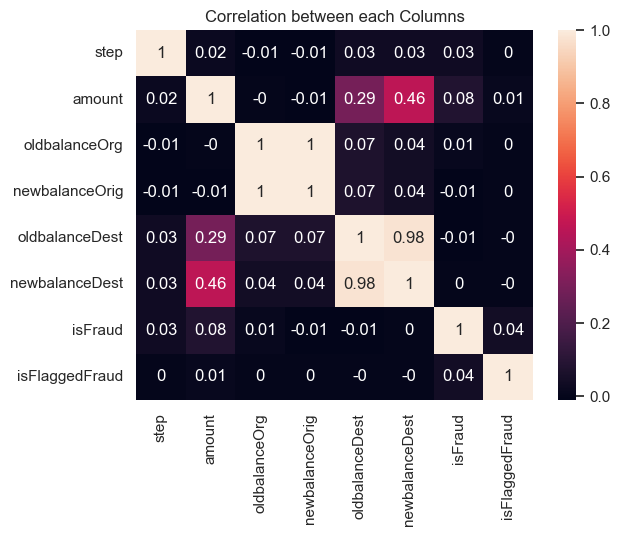

In [80]:
sns.heatmap(df.drop(['type', 'nameDest', 'nameOrig'], axis=1).corr().round(2), annot=True) # make the plot with all values rounded up to 2 decimal places and also all the
# values will be shown in each cell of the matrix
plt.title('Correlation between each Columns') # title for the plot
plt.show()

#### Box Plot

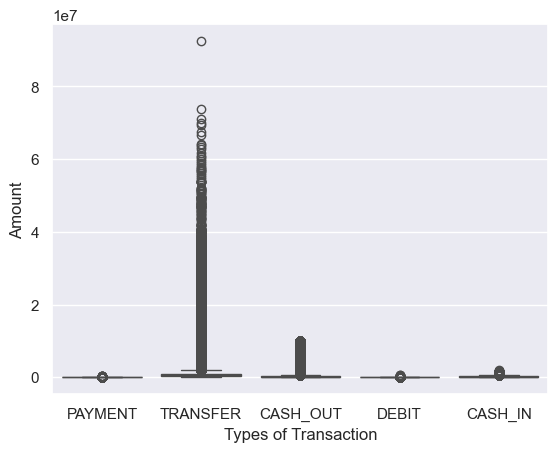

In [18]:
sns.set(style='darkgrid') # background color for the plot
sns.boxplot(x='type', y='amount', data=df_cp) # make the box plot with values of 'type' column on x-axis and values of 'amount'
# columns on y-axis
plt.xlabel('Types of Transaction') # label for x-axis
plt.ylabel('Amount') # label for y-axis
plt.show() # plot the box plot

#### Bar Plot

<Axes: xlabel='isFraud'>

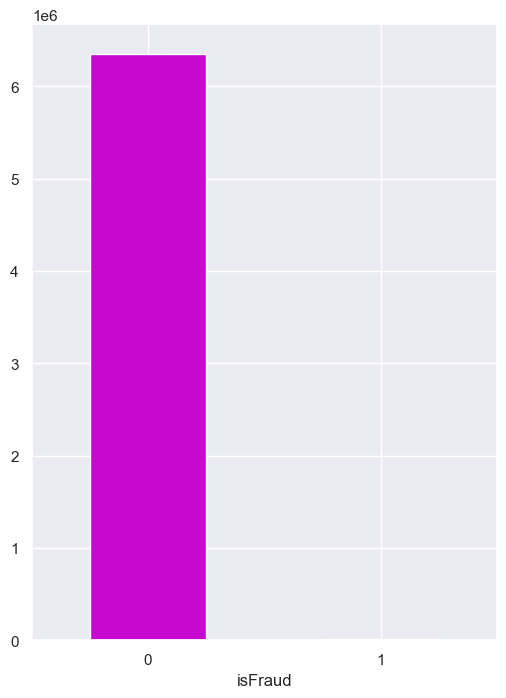

In [19]:
color = ['#c608d1', '#ff00fe'] # color bar plots of Is Fraud
df['isFraud'].value_counts().plot.bar(figsize=(6,8), color=color, rot=0) # make and show the plot with figure size 6 x 8 inches
# and rotation of the labels of x-axis set to 0

### Data Preparation

#### Feature Selection

In [20]:
df_cp = df_cp.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)
# I am dropping the columns 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest' and 'newbalanceDest' as noted in the description
# of the dataset. I am also dropping isFlaggedFraud because it is useless and nameDest and nameOrg columns because they are
# just ids of the senders and recievers

In [21]:
df_cp.head()

,step,type,amount,isFraud,DestType
0,1,PAYMENT,9839.64,0,M
1,1,PAYMENT,1864.28,0,M
2,1,TRANSFER,181.00,1,C
3,1,CASH_OUT,181.00,1,C
4,1,PAYMENT,11668.14,0,M


#### Feature Encoding

In [31]:
# Encoding features with data type strings
ohe_columns = ['type', 'DestType'] # features to be encoded to integers
ohe = OneHotEncoder(sparse_output=False).fit(df_cp[ohe_columns]) # encode the columns specified and return an array
encoded = ohe.transform(df_cp[ohe_columns]) # transformed the array
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out()) # converted array to a data frame
df_cp = pd.concat([df_cp[[x for x in df_cp.columns if x not in ohe_columns]].reset_index(drop=True),encoded_df], axis=1)
# finally concatenate both dataframes and in the process remove 'type' and 'DestType' columns with the encoded ones

#### Outlier Removal

In [33]:
df_cp = RemoveOutliers(df_cp, 3, 10) # Removing Outliers

#### Feature Scaling

We will using MinMaxScaler to scale data

In [34]:
scaled = MinMaxScaler().fit_transform(df_cp)
df_cp = pd.DataFrame(scaled, columns=df_cp.columns)

#### Under Sampling

As shown in the above bar chart of isFraud, we are dealing with imbalanced data. So I will balance data by using Under Sampling technique

In [35]:
# First splitting target column from other columns to perform Under Sampling

col = [c for c in df_cp.columns.to_list() if c not in ['isFraud']] # Save the names of columns apart from the target column
X = df_cp[col] # Split target column from other columns and save the columns in another data frame
Y = df_cp['isFraud'] # Split target column from other columns and save in another data frame

In [36]:
# Apply random under sampling for majority of the two values (which in this case is 0) to balance the data
RUS = RandomUnderSampler(random_state=42, sampling_strategy='majority')
X_samp,Y_samp = RUS.fit_resample(X,Y)

In [37]:
# Since the data frame is converted to a list of tuples, we need to convert them back to a data frame
X_samp = pd.DataFrame(X_samp, columns=col)
Y_samp = pd.DataFrame(Y_samp, columns=['isFraud'])

In [38]:
df_cp = pd.concat([X_samp, Y_samp], axis=1) # After converting, concatenate them

<Axes: xlabel='isFraud'>

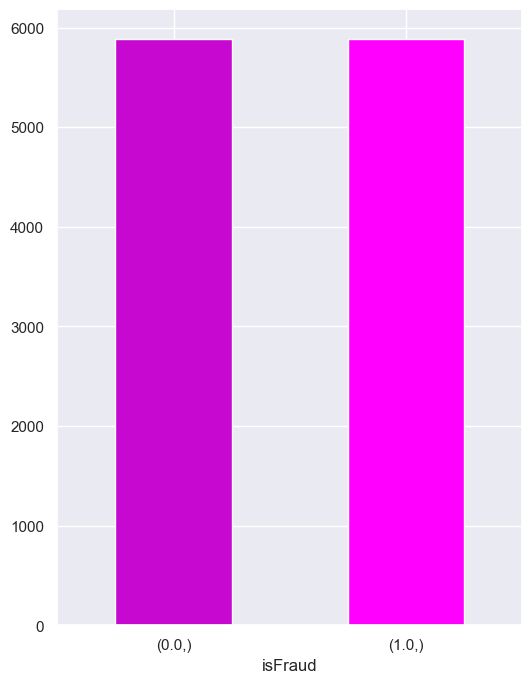

In [39]:
# Sample ratio after Under Sampling
color = ['#c608d1', '#ff00fe'] # color bar plots of Is Fraud
Y_samp.value_counts().plot.bar(figsize=(6,8), color=color, rot=0) # make and show the plot with figure size 6 x 8 inches
# and rotation of the labels of x-axis set to 0

### Model Training

In [41]:
# Again splitting data sets but now for training and testing the model
X = df_cp[col]
Y = df_cp['isFraud'].apply(int)

In [42]:
# Split the data into 2 seperate groups, one to train the model with and one to test the model with
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.90, random_state=42, stratify=df_cp['isFraud'])

#### Logistic Regression

In [87]:
log = LogisticRegression(random_state=42)
log.fit(X_train, Y_train)

LogisticRegression(random_state=42)

In [88]:
# Evaluating the model through different evaluation metrics
accuracy = accuracy_score(Y_test, log.predict(X_test))
precision = precision_score(Y_test, log.predict(X_test))
recall = recall_score(Y_test, log.predict(X_test))
f1 = f1_score(Y_test, log.predict(X_test))
conf_matrix = confusion_matrix(Y_test, log.predict(X_test))

In [89]:
# Showing the values
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8140916808149405
Precision: 0.7752976190476191
Recall: 0.8845500848896435
F1-score: 0.8263283108643933
Confusion Matrix:
 [[438 151]
 [ 68 521]]


#### Multinomial Naive-Bayes

In [84]:
mnb = MultinomialNB()
mnb.fit(X_train, Y_train)

MultinomialNB()

In [85]:
# Evaluating the model through different evaluation metrics
accuracy = accuracy_score(Y_test, mnb.predict(X_test))
precision = precision_score(Y_test, mnb.predict(X_test))
recall = recall_score(Y_test, mnb.predict(X_test))
f1 = f1_score(Y_test, mnb.predict(X_test))
conf_matrix = confusion_matrix(Y_test, mnb.predict(X_test))

In [86]:
# Showing the values
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7809847198641766
Precision: 0.6953955135773318
Recall: 1.0
F1-score: 0.8203342618384402
Confusion Matrix:
 [[331 258]
 [  0 589]]


### Random Forests

In [65]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy')
rf.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [66]:
# Evaluating the model through different evaluation metrics
accuracy = accuracy_score(Y_test, rf.predict(X_test))
precision = precision_score(Y_test, rf.predict(X_test))
recall = recall_score(Y_test, rf.predict(X_test))
f1 = f1_score(Y_test, rf.predict(X_test))
conf_matrix = confusion_matrix(Y_test, rf.predict(X_test))

In [67]:
# Showing the values
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.870118845500849
Precision: 0.8645484949832776
Recall: 0.8777589134125636
F1-score: 0.8711036225779275
Confusion Matrix:
 [[508  81]
 [ 72 517]]
